<a href="https://colab.research.google.com/github/Rafagars/Modern-Portfolio-Theory/blob/main/ProyectoFinancierasII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto I CO5516 Matematicas Financieras II : Construcción y Análisis de la Frontera Eficiente y Validación del CAPM

## Resumen


Este proyecto aplica los conceptos fundamentales de la teoría de portafolios de Markowitz y el Modelo de
Valoración de Activos de Capital (CAPM) utilizando datos históricos reales. Se realiza un análisis de las diez
acciones más relevantes del índice S&P 500, recolectando sus datos históricos de precios de los últimos cinco
años para calcular sus rendimientos logarítmicos, estimar el vector de rendimientos esperados y la matriz de
varianza-covarianza. Posteriormente, se construye la Frontera Eficiente de Markowitz y se identifica el
Portafolio de Mínima Varianza Global (MVP). Asumiendo el bono del Tesoro de EE. UU. como proxy del activo
libre de riesgo, se determina la Línea de Mercado de Capitales (CML) y el Portafolio de Tangencia. Se calculan
los Betas (β) de cada acción respecto al índice S&P 500 (proxy del Portafolio de Mercado) para luego graficar la
Línea de Mercado de Valores (SML) teórica. Por último, se comparan los rendimientos esperados históricos con
los predichos por el CAPM (SML) y se calculan las Alfas de Jensen, con el fin de discutir si el CAPM se valida
para estos activos.

## Abstract

This project applies the fundamental concepts of Markowitz portfolio theory and the Capital Asset Pricing
Model (CAPM) using real historical data. An analysis is conducted on the ten most influential stocks of the S&P
500 index, collecting their historical price data over the past five years to calculate their logarithmic returns,
estimate the expected return vector, and the variance-covariance matrix. Subsequently, the Markowitz Efficient
Frontier is constructed, and the Global Minimum Variance Portfolio (MVP) is identified. Assuming U.S.
Treasury bonds as a proxy for the risk-free asset, the Capital Market Line (CML) and the Tangency Portfolio are
determined. Betas (β) for each stock are calculated with respect to the S&P 500 index (as a proxy for the Market
Portfolio), and the theoretical Security Market Line (SML) is then plotted. Finally, historical expected returns are
compared with those predicted by the CAPM (SML), and Jensen's Alphas are calculated, in order to discuss
whether the CAPM is validated for these assets.

# Instalamos y cargamos las librerias necesarias para nuestro analisis

In [ ]:
!pip install pyPortfolioOpt
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 13.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import yfinance as yf

#Cargamos las libreria Pypfopt que nos ayudara con nuestro analisis financiero
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

# Definimos el periodo de tiempo de nuestro analisis y las acciones que queremos evaluar

In [ ]:
fecha_inicio = dt.datetime(2020, 6, 1)
fecha_final = dt.datetime(2025, 5, 31)

In [ ]:
lista_activos = ['MSFT', 'NVDA', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'BRK-B', 'GOOG'] #Tomamos las 10 acciones mas influyentes del S&P500
portfolio = yf.download(lista_activos, start=fecha_inicio, end=fecha_final) #Descargamos la informacion de los ultimos 5 años

/tmp/ipython-input-4-2253968691.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  portfolio = yf.download(lista_activos, start=fecha_inicio, end=fecha_final) #Descargamos la informacion de los ultimos 5 años
[*********************100%***********************]  10 of 10 completed


In [ ]:
portfolio = portfolio['Close'].dropna()
#Antes se usaba Adj Close para los calculos pero al parecer las nuevas versiones de la libreria hacen lo necesario para que baste con Close

In [ ]:
portfolio.head()

Ticker,AAPL,AMZN,AVGO,BRK-B,GOOG,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,
2020-06-01,78.215126,123.552002,25.464314,183.839996,71.167969,71.315788,230.644669,175.166779,8.773313,59.873333
2020-06-02,78.577209,123.620499,26.172949,185.940002,71.535774,71.685577,231.450256,177.159622,8.792247,58.770668
2020-06-03,79.009773,123.919998,27.180138,190.820007,71.394630,71.533485,228.904236,177.590744,8.736702,58.863998
2020-06-04,78.329330,123.029999,27.123940,192.050003,70.191772,70.293427,225.055313,175.253021,8.737702,57.625332
2020-06-05,80.560234,124.150002,27.843111,200.660004,71.494530,71.571762,229.510895,179.353622,8.890696,59.043999


In [ ]:
portfolio.to_csv('portfolio.csv', index=True) #Convertimos a archivo csv nuestra data descargada
portfolio = pd.read_csv('portfolio.csv', index_col="Date", parse_dates=True) #La cargamos ahora como un dataframe usando pandas

<Axes: xlabel='Date'>

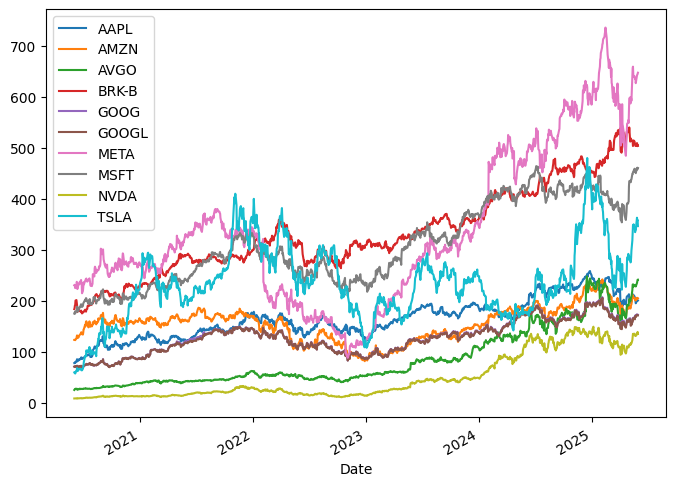

In [ ]:
#@title Grafico del desempeño de las acciones en estos ultimos 5 años
portfolio[portfolio.index >= "2020-06-01"].plot(figsize=(8,6)) #Graficamos el comportamiento de las acciones estos ultimos 5 años

In [ ]:
#@title Activo libre de riesgo. Tomamos los bonos del Tesoro de E.E.U.U
rf = 0.044

# Calculo de los Rendimientos y Matriz de Varianza - Covarianza

In [ ]:
#@title Calculamos los rendimientos logaritmicos
rendimientos_log = np.log(portfolio).diff()
rendimientos_log.dropna(inplace=True)
rendimientos_log

,AAPL,AMZN,AVGO,BRK-B,GOOG,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,,,,
2020-06-02,0.004619,0.000554,0.027448,0.011358,0.005155,0.005172,0.003487,0.011313,0.002156,-0.018588
2020-06-03,0.005490,0.002420,0.037760,0.025907,-0.001975,-0.002124,-0.011061,0.002431,-0.006338,0.001587
2020-06-04,-0.008649,-0.007208,-0.002070,0.006425,-0.016992,-0.017487,-0.016958,-0.013251,0.000114,-0.021267
2020-06-05,0.028083,0.009062,0.026169,0.043856,0.018390,0.018022,0.019604,0.023129,0.017358,0.024321
2020-06-08,0.005895,0.016401,0.001387,0.004475,0.005698,0.005554,0.002726,0.006178,-0.012976,0.070045
...,...,...,...,...,...,...,...,...,...,...
2025-05-23,-0.030711,-0.010443,-0.007882,-0.000218,-0.013994,-0.014145,-0.015052,-0.010342,-0.011662,-0.004997
2025-05-27,0.024984,0.024718,0.029849,0.011258,0.025557,0.025956,0.024044,0.023078,0.031563,0.067097
2025-05-28,0.001048,-0.006330,0.015913,-0.011954,-0.003455,-0.003128,0.001960,-0.007255,-0.005105,-0.016644


In [ ]:
#@title Rendimiento anual esperado de cada accion
rendimientos_anuales = rendimientos_log.mean() * 252 #El Rendimiento esperado anual se puede ver como la media de los rendimientos por los 252 dias de un año financiero
rendimientos_anuales

,0
AAPL,0.189220
AMZN,0.101602
AVGO,0.451352
BRK-B,0.202329
GOOG,0.177800
GOOGL,0.176090
META,0.206948
MSFT,0.193870
NVDA,0.548632
TSLA,0.352225


<Axes: title={'center': 'Rendimiento anual esperado de los activos'}>

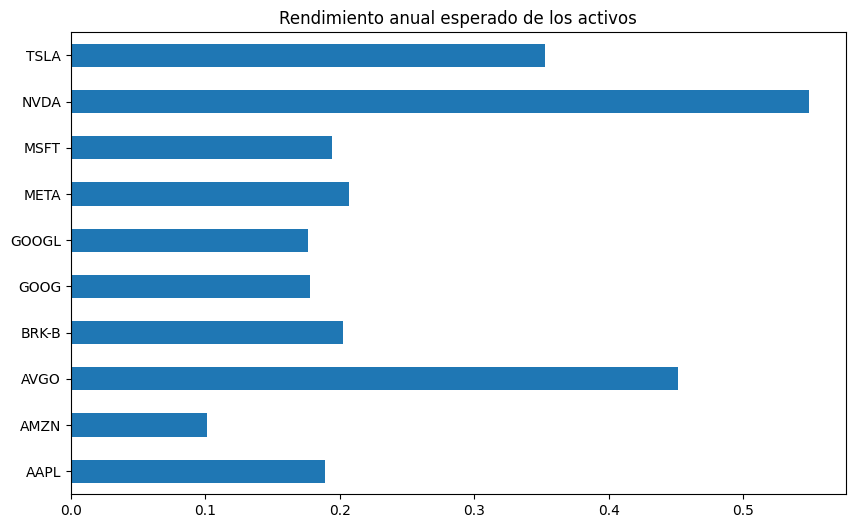

In [ ]:
rendimientos_anuales.plot.barh(figsize=(10,6), title='Rendimiento anual esperado de los activos')

In [ ]:
#@title Rendimiento anual esperado utilizando la libreria PypfOpt
mu = expected_returns.mean_historical_return(portfolio, frequency=252, log_returns=True, compounding=False) #Calculamos el rendimiento esperado historico para comparar
mu #Coinciden con lo obtenido calculandolo nosotros mismo

,0
AAPL,0.189220
AMZN,0.101602
AVGO,0.451352
BRK-B,0.202329
GOOG,0.177800
GOOGL,0.176090
META,0.206948
MSFT,0.193870
NVDA,0.548632
TSLA,0.352225


In [ ]:
# @title Matriz de Varianza - Covarianza
matriz_cov = risk_models.sample_cov(portfolio, frequency=252) #Matriz de Varianza - Covarianza anual
matriz_cov

,AAPL,AMZN,AVGO,BRK-B,GOOG,GOOGL,META,MSFT,NVDA,TSLA
AAPL,0.090338,0.064205,0.061440,0.023186,0.054336,0.054596,0.069884,0.054753,0.086887,0.096796
AMZN,0.064205,0.127774,0.073475,0.021514,0.072166,0.071951,0.098846,0.066984,0.109821,0.106160
AVGO,0.061440,0.073475,0.165581,0.021083,0.059827,0.060484,0.079610,0.060538,0.143146,0.114860
BRK-B,0.023186,0.021514,0.021083,0.033488,0.021751,0.021523,0.024225,0.018636,0.025357,0.028148
GOOG,0.054336,0.072166,0.059827,0.021751,0.096416,0.096180,0.083260,0.058317,0.090474,0.082507
GOOGL,0.054596,0.071951,0.060484,0.021523,0.096180,0.096878,0.083350,0.058600,0.090905,0.082500
META,0.069884,0.098846,0.079610,0.024225,0.083260,0.083350,0.194668,0.071324,0.120262,0.098761
MSFT,0.054753,0.066984,0.060538,0.018636,0.058317,0.058600,0.071324,0.073733,0.093011,0.078320
NVDA,0.086887,0.109821,0.143146,0.025357,0.090474,0.090905,0.120262,0.093011,0.281182,0.162688
TSLA,0.096796,0.106160,0.114860,0.028148,0.082507,0.082500,0.098761,0.078320,0.162688,0.411198


In [ ]:
# @title Riesgo anual
riesgo_anual = rendimientos_log.std() * np.sqrt(252) #Riesgo anual que es lo mismo que la desviacion estandar anual
riesgo_anual #Podemos ver que coincide con la raiz de cada una de las varianzas de la matriz

,0
AAPL,0.299609
AMZN,0.357168
AVGO,0.403000
BRK-B,0.182963
GOOG,0.310662
GOOGL,0.311347
META,0.445435
MSFT,0.271241
NVDA,0.526477
TSLA,0.638103


In [ ]:
#Se usa "encogimiento" de la covarianza como recomienda la documentacion de PypfOpt para obtener una mejor estimacion de la matriz de covarianza
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
S

,AAPL,AMZN,AVGO,BRK-B,GOOG,GOOGL,META,MSFT,NVDA,TSLA
AAPL,0.090924,0.063522,0.060787,0.022939,0.053758,0.054015,0.069140,0.054170,0.085963,0.095766
AMZN,0.063522,0.127961,0.072694,0.021286,0.071399,0.071186,0.097795,0.066272,0.108653,0.105031
AVGO,0.060787,0.072694,0.165366,0.020859,0.059190,0.059841,0.078763,0.059894,0.141624,0.113639
BRK-B,0.022939,0.021286,0.020859,0.034678,0.021520,0.021294,0.023967,0.018438,0.025088,0.027849
GOOG,0.053758,0.071399,0.059190,0.021520,0.096936,0.095157,0.082375,0.057697,0.089511,0.081629
GOOGL,0.054015,0.071186,0.059841,0.021294,0.095157,0.097393,0.082464,0.057977,0.089938,0.081622
META,0.069140,0.097795,0.078763,0.023967,0.082375,0.082464,0.194144,0.070565,0.118983,0.097711
MSFT,0.054170,0.066272,0.059894,0.018438,0.057697,0.057977,0.070565,0.074494,0.092022,0.077487
NVDA,0.085963,0.108653,0.141624,0.025088,0.089511,0.089938,0.118983,0.092022,0.279738,0.160958
TSLA,0.095766,0.105031,0.113639,0.027849,0.081629,0.081622,0.097711,0.077487,0.160958,0.408371


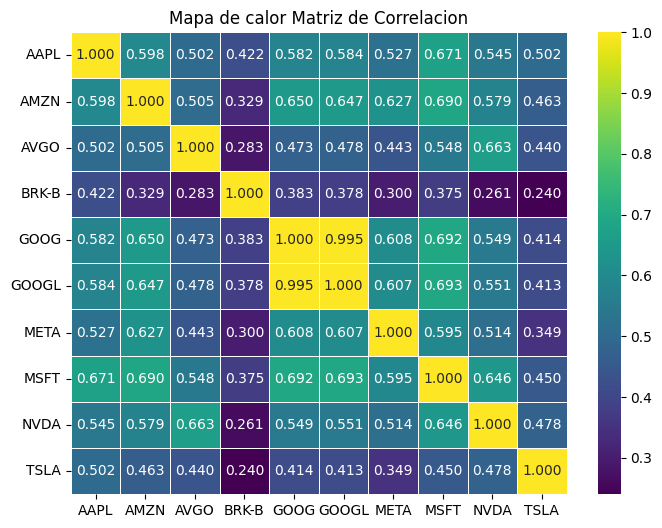

In [ ]:
# @title Mapa de Calor de Matriz de Correlaccion
plt.figure(figsize=(8, 6))
sns.heatmap(
  risk_models.cov_to_corr(matriz_cov),
  annot=True, #Muestra los valores de la correlacion
  cmap='viridis',
  fmt=".3f",        # Format the annotation values
  linewidths=.5
)
plt.title('Mapa de calor Matriz de Correlacion')
plt.show()

# Frontera Eficiente de Markowitz

## Sin permitir ventar en corto (wᵢ ≥ 0)

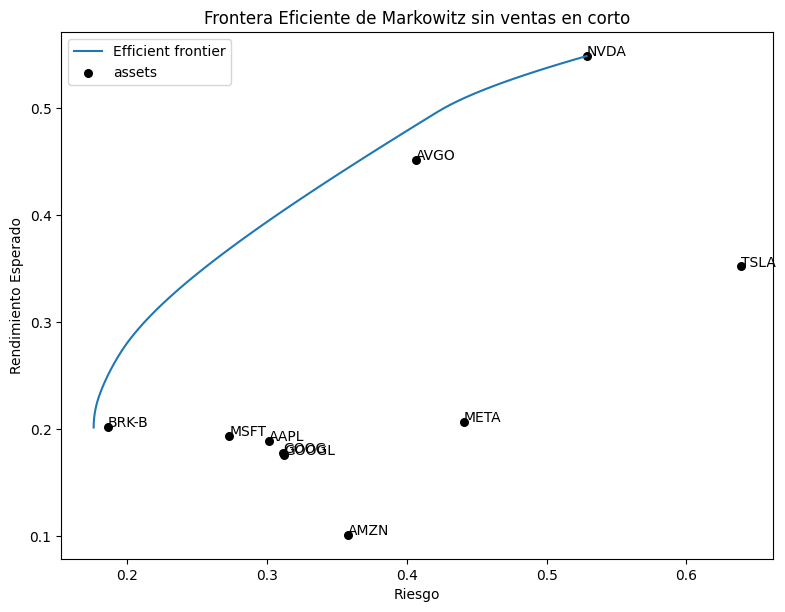

In [ ]:
# @title Grafico de Frontera Eficiente sin ventas en corto
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))

fig, ax = plt.subplots(figsize= (8,6))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, show_tickers=True)
plt.xlabel('Riesgo')
plt.ylabel('Rendimiento Esperado')
plt.title('Frontera Eficiente de Markowitz sin ventas en corto')
plt.show()

### Pesos para el minimo riesgo

In [ ]:
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
weights = ef.min_volatility()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'AAPL': 0.01477, 'AMZN': 0.0, 'AVGO': 0.00758, 'BRK-B': 0.76185, 'GOOG': 0.0, 'GOOGL': 0.02487, 'META': 0.0, 'MSFT': 0.19093, 'NVDA': 0.0, 'TSLA': 0.0}


<Axes: xlabel='Weight'>

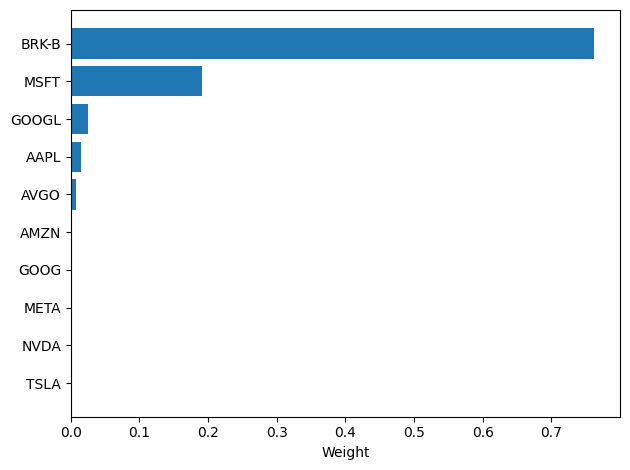

In [ ]:
#@title Grafico de barras de los pesos para el minimo riesgo
plotting.plot_weights(cleaned_weights)

In [ ]:
#@title Evaluacion del Portafolio con el minimo riesgo
ef.portfolio_performance(verbose=True)

Expected annual return: 20.2%
Annual volatility: 17.6%
Sharpe Ratio: 1.15


(np.float64(0.2017547332934918),
 np.float64(0.17597271643758797),
 np.float64(1.1465114443752302))

### Pesos para el punto con el Maximo Sharpe

In [ ]:
ef2 = EfficientFrontier(mu, S, weight_bounds=(0, 1))
weights2 = ef2.max_sharpe(risk_free_rate=rf) #Nuestro activo libre de riesgo tiene una tasa de 4.4%

cleaned_weights2 = ef2.clean_weights()
print(dict(cleaned_weights2))

{'AAPL': 0.0, 'AMZN': 0.0, 'AVGO': 0.25254, 'BRK-B': 0.59008, 'GOOG': 0.0, 'GOOGL': 0.0, 'META': 0.0, 'MSFT': 0.0, 'NVDA': 0.15738, 'TSLA': 0.0}


<Axes: xlabel='Weight'>

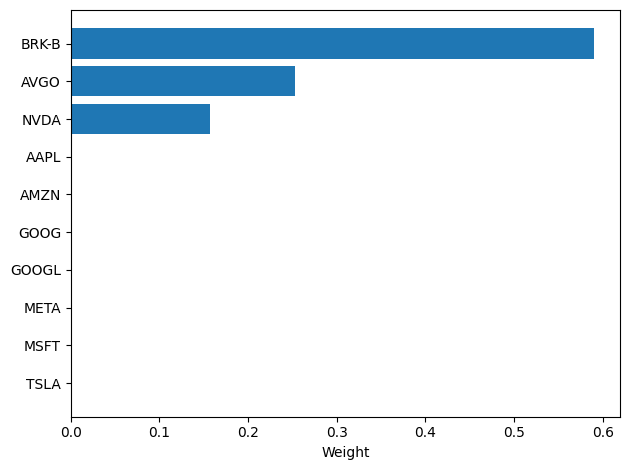

In [ ]:
# @title Grafico de barra de los pesos para el MSRP
plotting.plot_weights(cleaned_weights2)

In [ ]:
#@title Evaluacion del Portafolio con el MSRP
ef2.portfolio_performance(verbose=True, risk_free_rate=rf)

Expected annual return: 32.0%
Annual volatility: 22.7%
Sharpe Ratio: 1.21


(np.float64(0.319717422657267),
 np.float64(0.22734004964566734),
 np.float64(1.2127974067349803))

### Calculos para la Simulacion Monte Carlo

In [ ]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Rendimientos del Portafolio de muestra:", rets)
print("Riesgos del Portafolio de Muestra: \n", stds)

Rendimientos del Portafolio de muestra: [0.24656124 0.21752039 0.21762327 ... 0.24754878 0.26569619 0.28296903]
Riesgos del Portafolio de Muestra: 
 0       0.280251
1       0.253674
2       0.268353
3       0.294092
4       0.260111
          ...   
9995    0.286039
9996    0.294277
9997    0.273235
9998    0.277377
9999    0.295424
Length: 10000, dtype: float64


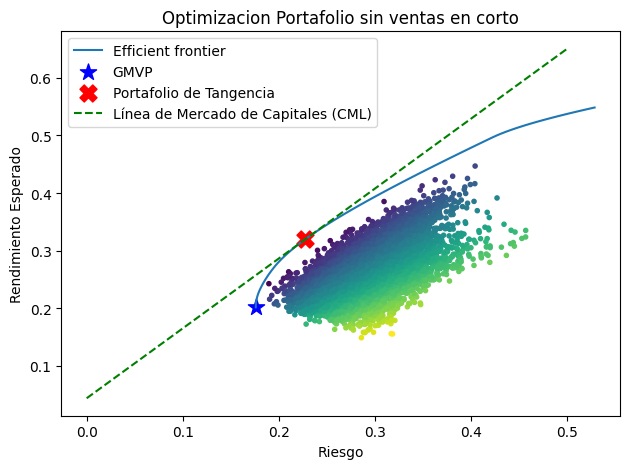

In [ ]:
# Graficamos la Frontera de Eficiencia usando simulacion de Monte Carlo
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Buscamos y graficamos la Minima Varianza
ef2 = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef2.min_volatility()
ret_min, std_min, _ = ef2.portfolio_performance()

# Graficamos los Portafolios aleatorios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_min, ret_min, c='blue', marker='*',s=150, label= 'GMVP')

# Buscamos y graficamos el punto Tangente
ef3 = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef3.max_sharpe(risk_free_rate=rf)
ret_tangent, std_tangent, _ = ef3.portfolio_performance(risk_free_rate=rf)

# MSRP (Portafolio de Tangencia)
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Portafolio de Tangencia')

# Graficar la Línea de Mercado de Capitales (CML)
x = np.linspace(0, 0.5, 100)
cml_y = rf + (ret_tangent - rf)/std_tangent * x
ax.plot(x, cml_y, linestyle='--', color='green', label='Línea de Mercado de Capitales (CML)')

# Formato
ax.set_title("Optimizacion Portafolio sin ventas en corto")
ax.legend()
plt.tight_layout()
plt.xlabel('Riesgo')
plt.ylabel('Rendimiento Esperado')
plt.show()

## Permitiendo ventas en corto

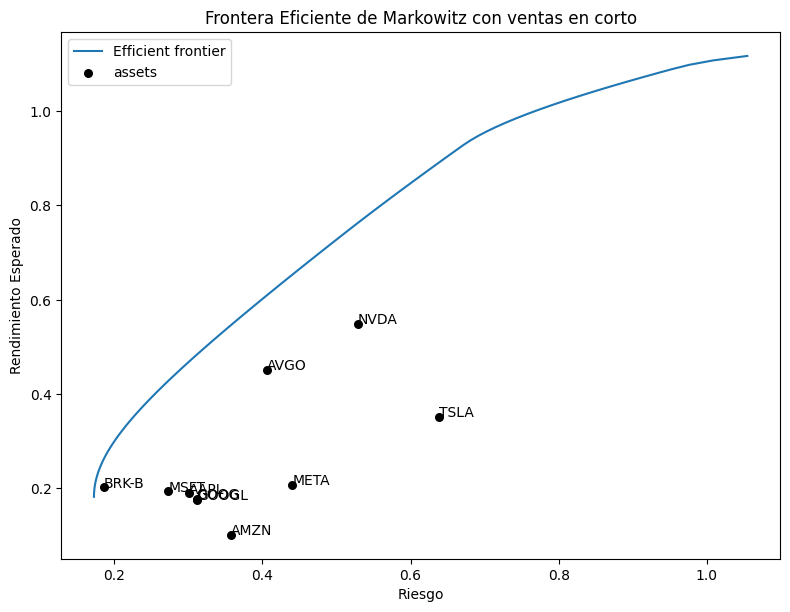

In [ ]:
# @title Grafico de Frontera Eficiente con ventas en corto
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))

fig, ax = plt.subplots(figsize= (8,6))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, show_tickers=True)
plt.xlabel('Riesgo')
plt.ylabel('Rendimiento Esperado')
plt.title('Frontera Eficiente de Markowitz con ventas en corto')
plt.show()

### Pesos para el minimo riesgo

In [ ]:
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
weights = ef.min_volatility()

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))

{'AAPL': 0.04631, 'AMZN': 0.01307, 'AVGO': 0.05676, 'BRK-B': 0.72522, 'GOOG': 0.00895, 'GOOGL': 0.04523, 'META': -0.03333, 'MSFT': 0.2357, 'NVDA': -0.07255, 'TSLA': -0.02536}


<Axes: xlabel='Weight'>

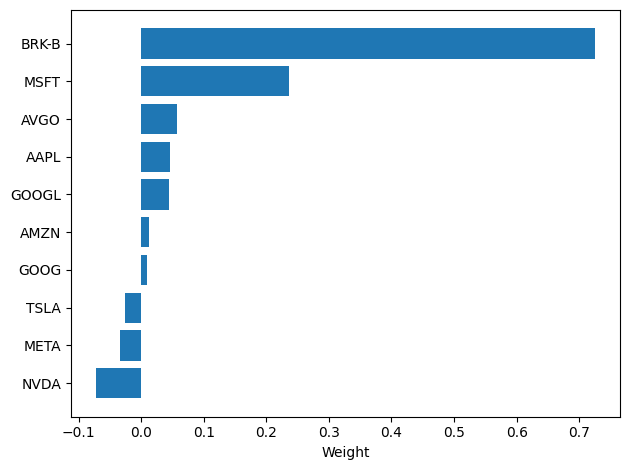

In [ ]:
plotting.plot_weights(cleaned_weights)

In [ ]:
#@title Evaluacion del Portafolio con el minimo riesgo
ef.portfolio_performance(verbose=True)

Expected annual return: 18.2%
Annual volatility: 17.3%
Sharpe Ratio: 1.05


(np.float64(0.18206020744228935),
 np.float64(0.172771784634731),
 np.float64(1.0537612251166801))

### Pesos para MSRP



In [ ]:
ef2 = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
weights2 = ef2.max_sharpe(risk_free_rate=rf) #Nuestro activo libre de riesgo tiene una tasa de 4.4%

cleaned_weights2 = ef2.clean_weights()
print(dict(cleaned_weights2))

{'AAPL': -0.12085, 'AMZN': -0.5126, 'AVGO': 0.38605, 'BRK-B': 0.89294, 'GOOG': 0.13076, 'GOOGL': -0.18913, 'META': 0.00436, 'MSFT': 0.04587, 'NVDA': 0.33943, 'TSLA': 0.02318}


<Axes: xlabel='Weight'>

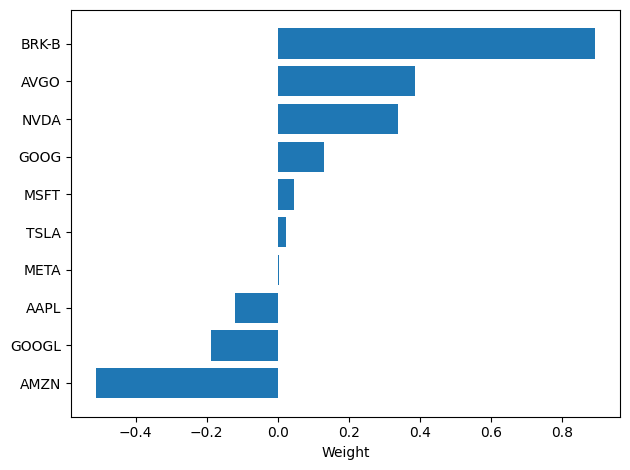

In [ ]:
#@title Grafico de barras pesos MSRP
plotting.plot_weights(cleaned_weights2)

In [ ]:
# @title Evaluacion del Portafolio MSRP
ef2.portfolio_performance(verbose=True, risk_free_rate=rf)

Expected annual return: 47.4%
Annual volatility: 30.5%
Sharpe Ratio: 1.41


(np.float64(0.47408726052209627),
 np.float64(0.3049417215712282),
 np.float64(1.4103916587931922))

### Calculos para la Simulacion Monte Carlo

In [ ]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities: \n", stds)

Sample portfolio returns: [0.28613563 0.26379151 0.18215247 ... 0.25490889 0.26682389 0.23242421]
Sample portfolio volatilities: 
 0       0.285513
1       0.282438
2       0.280323
3       0.321018
4       0.257350
          ...   
9995    0.253475
9996    0.268936
9997    0.270558
9998    0.312580
9999    0.281678
Length: 10000, dtype: float64


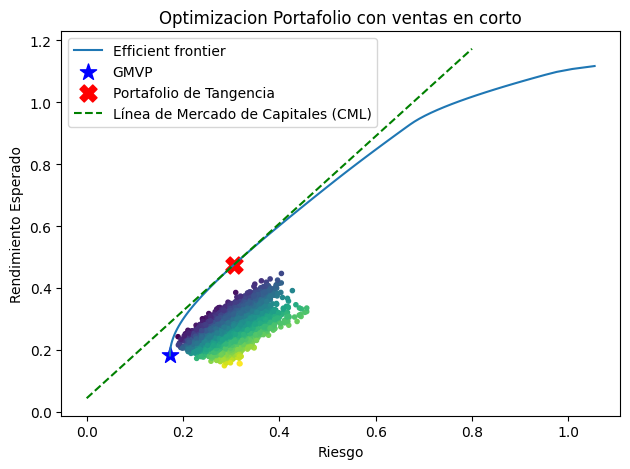

In [ ]:
# Graficamos la Frontera de Eficiencia usando simulacion de Monte Carlo
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Buscamos y graficamos la Minima Varianza
ef2 = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
ef2.min_volatility()
ret_min, std_min, _ = ef2.portfolio_performance()

# Graficamos los Portafolio aleatorios
ax.scatter(std_min, ret_min, c='blue', marker='*',s=150, label= 'GMVP')

# Buscamos y graficamos el punto Tangente
ef3 = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
ef3.max_sharpe(risk_free_rate=rf)
ret_tangent, std_tangent, _ = ef3.portfolio_performance(risk_free_rate=rf)

# Graficamos los Portafolios aleatorios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
ax.scatter(std_tangent, ret_tangent, c='red', marker='X',s=150, label= 'Portafolio de Tangencia')

# Graficar la Línea de Mercado de Capitales (CML)
x = np.linspace(0, 0.8, 100)
cml_y = rf + (ret_tangent - rf)/std_tangent * x
ax.plot(x, cml_y, linestyle='--', color='green', label='Línea de Mercado de Capitales (CML)')

# Formato
ax.set_title("Optimizacion Portafolio con ventas en corto")
ax.legend()
plt.tight_layout()
plt.xlabel('Riesgo')
plt.ylabel('Rendimiento Esperado')
plt.show()

# Definimos el valor de nuestro activo libre de riesgo y calculamos el valor esperado y varianza del Mercado

In [ ]:
#@title Activo libre de riesgo. Tomamos los bonos del Tesoro de E.E.U.U
rf = 0.044

In [ ]:
#@title Descargamos la informacion del indice S&P500
precios_mercado = yf.download("^GSPC", start=fecha_inicio, end=fecha_final)
precios_mercado = precios_mercado['Close'] #Asi tenemos los precios del mercado para calcular su rendimiento esperado

/tmp/ipython-input-30-1330586205.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  precios_mercado = yf.download("^GSPC", start=fecha_inicio, end=fecha_final)
[*********************100%***********************]  1 of 1 completed


In [ ]:
# @title Rendimientos Logaritmicos del Mercado
rendimientos_log_mercado = np.log(precios_mercado).diff()
rendimientos_log_mercado.dropna(inplace=True)
rendimientos_log_mercado

Ticker,^GSPC
Date,
2020-06-02,0.008177
2020-06-03,0.013557
2020-06-04,-0.003374
2020-06-05,0.025874
2020-06-08,0.011970
...,...
2025-05-23,-0.006731
2025-05-27,0.020253
2025-05-28,-0.005587


In [ ]:
#@title Rendimiento anual esperado del mercado
r_M = expected_returns.mean_historical_return(precios_mercado, log_returns=True, compounding=False)
r_M

,0
Ticker,
^GSPC,0.132403


In [ ]:
#@title Varianza anual del mercado
var_M = rendimientos_log_mercado.var() * 252
var_M

,0
Ticker,
^GSPC,0.031655


In [ ]:
# @title Desviacion estandar anual del mercado
sd_M = rendimientos_log_mercado.std() * np.sqrt(252)
sd_M

,0
Ticker,
^GSPC,0.177919


In [ ]:
# @title Calculamos la pendiente del CML que es lo mismo que el ratio de Sharpe
sharpe_ratio = (r_M - rf) / sd_M
sharpe_ratio

,0
Ticker,
^GSPC,0.496871


## Calculos del CAPM y SML

In [ ]:
# @title Rendimientos Esperados segun el CAPM
mu_capm = expected_returns.capm_return(portfolio, risk_free_rate = rf, market_prices=precios_mercado, log_returns=True, compounding=False)
mu_capm

,mkt
AAPL,0.156378
AMZN,0.170559
AVGO,0.179824
BRK-B,0.106122
GOOG,0.153797
GOOGL,0.153963
META,0.182659
MSFT,0.148098
NVDA,0.226484
TSLA,0.221031


<Axes: title={'center': 'Rendimineto anual esperado por CAPM de los activos'}>

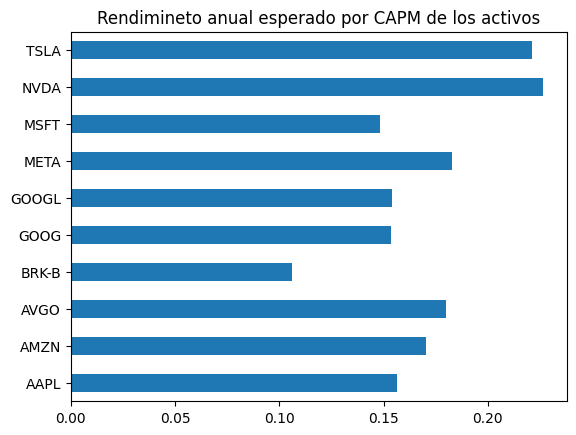

In [ ]:
mu_capm.plot.barh(title="Rendimineto anual esperado por CAPM de los activos")

In [ ]:
# @title Calculamos los Betas de cada accion
betas = (mu_capm - rf)/(r_M['^GSPC'] - rf) #Para estimar los betas calculados por pyportfolio
betas

,mkt
AAPL,1.271196
AMZN,1.431613
AVGO,1.536423
BRK-B,0.702718
GOOG,1.242004
GOOGL,1.243884
META,1.568493
MSFT,1.177536
NVDA,2.064227
TSLA,2.002545


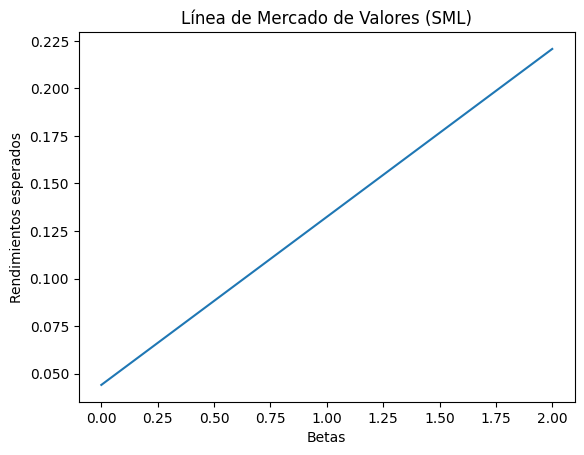

In [ ]:
# @title Grafica de la Linea de Mercado de Valores (SML)
x = [0, 1, 2]
y = [rf, r_M['^GSPC'], rf + 2*(r_M['^GSPC'] - rf)]
plt.plot(x, y)
plt.xlabel('Betas')
plt.ylabel('Rendimientos esperados')
plt.title('Línea de Mercado de Valores (SML)')
plt.show()

In [ ]:
# @title Calculamos los Alfas de Jensen calculando la diferencia entre los rendimientos esperados obtenidos al inicio y los rendimientos del CAPM
alpha = mu - mu_capm
alpha

,0
AAPL,0.032842
AMZN,-0.068957
AVGO,0.271528
BRK-B,0.096206
GOOG,0.024004
GOOGL,0.022127
META,0.024289
MSFT,0.045772
NVDA,0.322149
TSLA,0.131194
